In [12]:
# --- 1) Imports & Setup ---------------------------------------------

import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib: klare Standard-Settings (ohne seaborn)
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.alpha"] = 0.6

# Reproduzierbarkeit (falls wir irgendwo randomness verwenden)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_PATH = Path("/home/maxge/studies/bachelor_mechatronics/semester_5/exchange_UiA/IKT110_artificial_intelligence_architecture/IKT110_eckstein/handins/handin_1/data/traffic.jsonl")  # an deine Ordnerstruktur angepasst


Rows: 1031 | dep_min range: 420–1019 (07:00–16:59), duration range: 50–163 min


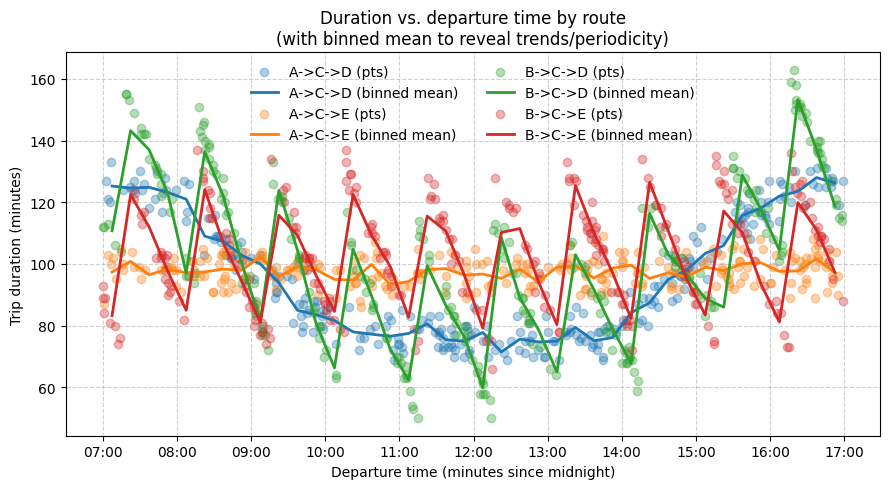

{'type': 'zscore', 'dep_min_min': 420.0, 'dep_min_max': 1019.0, 'mu': 728.9505334626576, 'sigma': 173.53796778530048}


In [ ]:
# --- 2) Daten laden, Feature-Engineering & Plot ----------------------

def _hhmm_to_minutes(hhmm: str) -> int:
    """Wandelt 'HH:MM' in Minuten seit Mitternacht um (z. B. '07:30' → 450)."""
    h, m = hhmm.split(":")
    return int(h) * 60 + int(m)

def load_traffic_df(jsonl_path: Path) -> pd.DataFrame:
    """
    Liest traffic.jsonl und erzeugt ein tidy DataFrame:
      - dep_min / arr_min: Minuten seit Tagesbeginn
      - duration_min: Fahrzeit in Minuten (wrap-around abgesichert)
    """
    df = pd.read_json(jsonl_path, lines=True)

    # Datensatz hat häufig das Feld 'depature' (Tippfehler). Harmonisieren:
    if "depature" in df.columns and "departure" not in df.columns:
        df = df.rename(columns={"depature": "departure"})

    # Zeiten parsen
    dep_min = df["departure"].map(_hhmm_to_minutes)
    arr_min = df["arrival"].map(_hhmm_to_minutes)

    # Dauer berechnen; falls Ankunft < Abfahrt (über Mitternacht), +24h
    duration = arr_min - dep_min
    duration = duration.where(duration >= 0, duration + 24 * 60)

    df_out = df.assign(
        dep_min=dep_min,
        arr_min=arr_min,
        duration_min=duration,
    )

    return df_out


# --- Feature-Scaling (z-Score oder Min-Max) --------------------------

def fit_scaler(dep_min: pd.Series, method: str = "zscore") -> dict:
    """
    Erzeugt Scaler-Parameter für dep_min.
    method: "zscore" (empfohlen) oder "minmax"
    """
    dep_min = dep_min.to_numpy()
    params = {"type": method, "dep_min_min": float(dep_min.min()), "dep_min_max": float(dep_min.max())}

    if method == "zscore":
        mu = float(dep_min.mean())
        sigma = float(dep_min.std(ddof=0)) or 1.0
        params.update({"mu": mu, "sigma": sigma})
    elif method == "minmax":
        dmin, dmax = params["dep_min_min"], params["dep_min_max"]
        rng = (dmax - dmin) or 1.0
        params.update({"min": dmin, "max": dmax, "range": rng})
    else:
        raise ValueError("method must be 'zscore' or 'minmax'")

    return params


def transform_dep_min(dep_min: pd.Series, scaler: dict, clip_out_of_range: bool = False) -> np.ndarray:
    """
    Wendet den Scaler auf dep_min an.
    - clip_out_of_range=True: clamp auf Trainingsbereich (empfohlen für Inferenz/Extrapolation).
    """
    x = dep_min.to_numpy().astype(float)

    if clip_out_of_range:
        lo, hi = scaler["dep_min_min"], scaler["dep_min_max"]
        x = np.clip(x, lo, hi)

    if scaler["type"] == "zscore":
        return (x - scaler["mu"]) / scaler["sigma"]
    elif scaler["type"] == "minmax":
        return (x - scaler["min"]) / scaler["range"]
    else:
        raise ValueError("unknown scaler type")


# --- Plot-Helfer: Duration vs. Departure mit geglätteter Trendlinie --

def plot_durations_by_route(df: pd.DataFrame, bin_minutes: int = 15) -> None:
    """
    Visualisiert pro Route:
      - Scatter: duration_min gegen dep_min
      - Geglättete binned-mean-Kurve (bin_minutes) zur Periodizitäts-Inspektion
    """
    dep_min_min = int(df["dep_min"].min())
    dep_min_max = int(df["dep_min"].max())

    # Bins & Zentren bereiten
    edges = list(range((dep_min_min // bin_minutes) * bin_minutes,
                       ((dep_min_max // bin_minutes) + 1) * bin_minutes + 1,
                       bin_minutes))
    centers = [(edges[i] + edges[i+1]) / 2 for i in range(len(edges) - 1)]

    fig, ax = plt.subplots()

    for route, sub in df.groupby("road", sort=True):
        # Punkte
        ax.scatter(sub["dep_min"], sub["duration_min"], alpha=0.35, label=f"{route} (pts)")

        # Binned mean
        bin_ids = pd.cut(sub["dep_min"], bins=edges, right=False, include_lowest=True, labels=False)
        binned = (
            pd.DataFrame({"bin": bin_ids, "duration": sub["duration_min"]})
            .dropna()
            .groupby("bin", as_index=False)["duration"].mean()
        )
        if not binned.empty:
            x_line = [centers[int(i)] for i in binned["bin"]]
            y_line = binned["duration"].to_list()
            ax.plot(x_line, y_line, linewidth=2, label=f"{route} (binned mean)")

    # Achsenbeschriftung / Ticks in HH:MM
    ax.set_xlabel("Departure time (minutes since midnight)")
    ax.set_ylabel("Trip duration (minutes)")
    ax.set_title("Duration vs. departure time by route\n(with binned mean to reveal trends/periodicity)")

    start_hour = dep_min_min // 60
    end_hour = math.ceil(dep_min_max / 60)
    xticks = [h * 60 for h in range(start_hour, end_hour + 1)]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{h:02d}:00" for h in range(start_hour, end_hour + 1)])

    ax.legend(loc="best", ncol=2, frameon=False)
    plt.tight_layout()
    plt.show()


# --- Ausführung: Laden, Skalieren, Plot ------------------------------

# 1) Daten laden
df = load_traffic_df(DATA_PATH)

# 2) Scaler wählen & fitten (zscore empfohlen; alternativ "minmax")
SCALER_METHOD = "zscore"  # oder: "minmax"
scaler = fit_scaler(df["dep_min"], method=SCALER_METHOD)

# 3) Transformierte Feature-Spalte hinzufügen (fürs spätere Training)
df["dep_scaled"] = transform_dep_min(df["dep_min"], scaler, clip_out_of_range=False)

# 4) Schneller Blick auf den Bereich & Grundstats
print(
    f"Rows: {len(df)} | dep_min range: {df.dep_min.min():.0f}–{df.dep_min.max():.0f} "
    f"({df.dep_min.min()//60:02d}:{df.dep_min.min()%60:02d}–{df.dep_min.max()//60:02d}:{df.dep_min.max()%60:02d}), "
    f"duration range: {df.duration_min.min():.0f}–{df.duration_min.max():.0f} min"
)
df.head(10)

plot_durations_by_route(df, bin_minutes=15)

In [24]:
def plot_hourly_means_with_errorbars(df: pd.DataFrame) -> None:
    """
    Stündliche Mittelwerte ± Standardabweichung der Dauer, getrennt nach Route.
    """
    tmp = df.copy()
    tmp["hour"] = (tmp["dep_min"] // 60).astype(int)

    fig, ax = plt.subplots(figsize=(9, 5))
    for route, sub in tmp.groupby("road", sort=True):
        g = sub.groupby("hour")["duration_min"].agg(["mean", "std"]).reset_index()
        ax.errorbar(g["hour"], g["mean"], yerr=g["std"], fmt="-o", capsize=3, label=route)

    ax.set_xlabel("Departure hour (HH)")
    ax.set_ylabel("Trip duration mean ± std (min)")
    ax.set_title("Hourly duration statistics by route")
    ax.set_xticks(sorted(tmp["hour"].unique()))
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


def plot_best_route_by_time(df: pd.DataFrame, bin_minutes: int = 15) -> None:
    """
    Ermittelt je Zeit-Bin die Route mit der kleinsten mittleren Dauer und
    zeigt sie als „Stufen“-Kurve über der Zeit. Y-Achse: Routenlabels.
    """
    dep_min_min = int(df["dep_min"].min())
    dep_min_max = int(df["dep_min"].max())
    edges = list(range((dep_min_min // bin_minutes) * bin_minutes,
                       ((dep_min_max // bin_minutes) + 1) * bin_minutes + 1,
                       bin_minutes))
    centers = np.array([(edges[i] + edges[i+1]) / 2 for i in range(len(edges) - 1)])

    routes = sorted(df["road"].unique().tolist())

    # Matrix: Zeile = Bin, Spalte = Route, Wert = mittlere Dauer
    M = np.full((len(centers), len(routes)), np.nan)
    for j, route in enumerate(routes):
        sub = df[df["road"] == route]
        bin_ids = pd.cut(sub["dep_min"], bins=edges, right=False, include_lowest=True, labels=False)
        binned = pd.DataFrame({"bin": bin_ids, "duration": sub["duration_min"]}).dropna()
        if not binned.empty:
            means = binned.groupby("bin")["duration"].mean()
            for b, val in means.items():
                M[int(b), j] = val

    # Für jeden Bin die beste Route bestimmen (ignoriere NaN-Zeilen)
    best_idx = []
    valid_centers = []
    for i in range(M.shape[0]):
        row = M[i, :]
        if np.all(np.isnan(row)):
            continue
        best_idx.append(int(np.nanargmin(row)))
        valid_centers.append(centers[i])

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(valid_centers, best_idx, drawstyle="steps-mid")
    ax.set_yticks(range(len(routes)))
    ax.set_yticklabels(routes)
    ax.set_xlabel("Departure time (minutes since midnight)")
    ax.set_title(f"Best route by time (binned mean, {bin_minutes}-min bins)")

    start_hour = dep_min_min // 60
    end_hour = math.ceil(dep_min_max / 60)
    xticks = [h * 60 for h in range(start_hour, end_hour + 1)]
    ax.set_xticks(xticks)
    ax.set_xticklabels([f"{h:02d}:00" for h in range(start_hour, end_hour + 1)])
    plt.tight_layout()
    plt.show()


def plot_duration_histograms(df: pd.DataFrame, bins: int = 20) -> None:
    """
    Überlagerte Histogramme der Dauer pro Route (Outline-Style für Übersicht).
    """
    fig, ax = plt.subplots(figsize=(9, 5))
    for route, sub in df.groupby("road", sort=True):
        ax.hist(sub["duration_min"], bins=bins, histtype="step", label=route)
    ax.set_xlabel("Trip duration (min)")
    ax.set_ylabel("Count")
    ax.set_title("Duration distribution by route")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


def plot_ecdf_by_route(df: pd.DataFrame) -> None:
    """
    Empirische Verteilungsfunktion (ECDF) der Dauer pro Route.
    Zeigt direkt, wie oft eine Route 'schneller als X Minuten' ist.
    """
    fig, ax = plt.subplots(figsize=(9, 5))
    for route, sub in df.groupby("road", sort=True):
        x = np.sort(sub["duration_min"].to_numpy())
        y = np.arange(1, len(x) + 1) / len(x)
        ax.plot(x, y, label=route)
    ax.set_xlabel("Trip duration (min)")
    ax.set_ylabel("ECDF")
    ax.set_title("Empirical CDF of durations by route")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


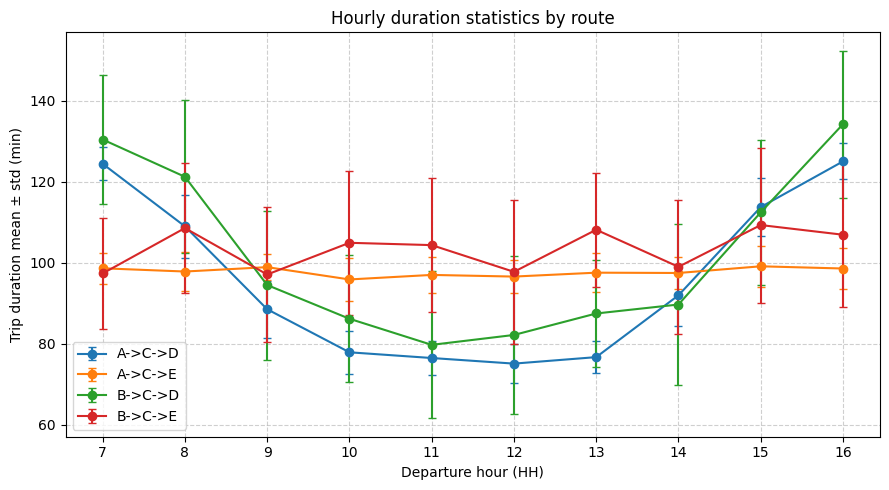

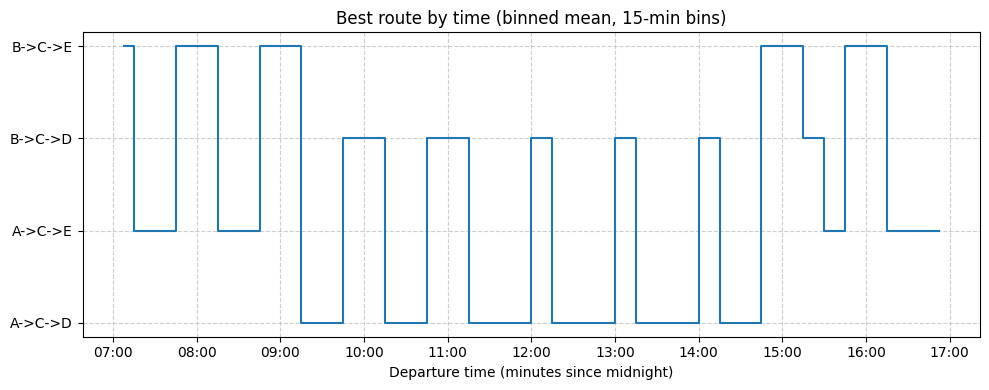

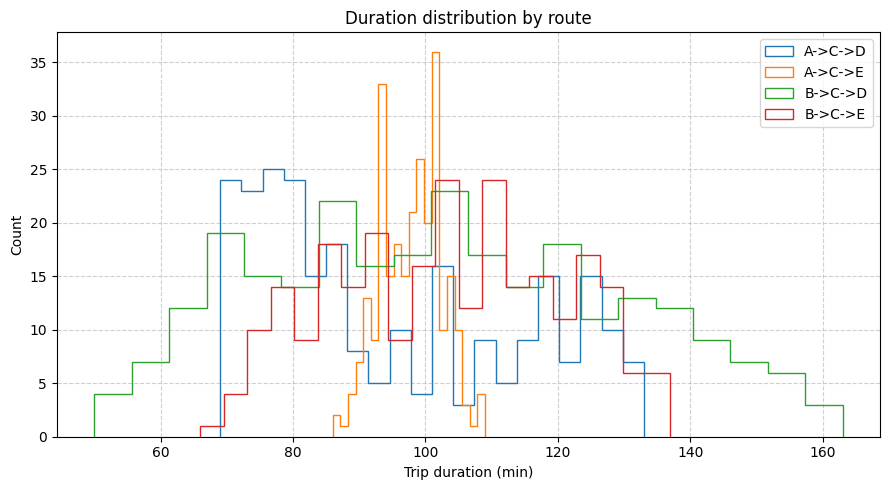

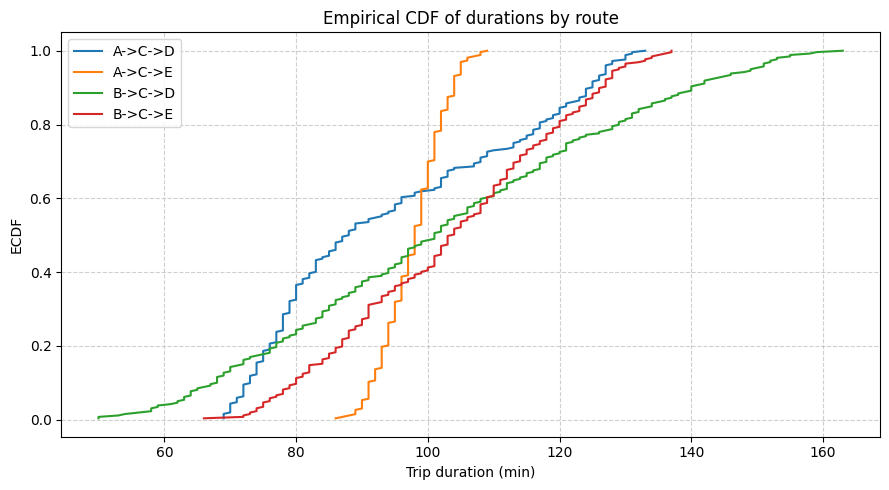

In [ ]:
plot_hourly_means_with_errorbars(df)
plot_best_route_by_time(df, bin_minutes=15)
plot_duration_histograms(df, bins=20)
plot_ecdf_by_route(df)

In [ ]:
df.info()

mu = scaler.get("mu", 0)
sigma = scaler.get("sigma", 1)

z_min = (df.dep_min.min() - mu) / sigma
z_max = (df.dep_min.max() - mu) / sigma
q = df.dep_min.quantile([0.01, 0.99])
z_q01, z_q99 = (q.iloc[0]-mu)/sigma, (q.iloc[1]-mu)/sigma

print(f"dep_min z-score range: {z_min:.2f} to {z_max:.2f}")
print(f"dep_min z-score 1%-99% quantiles: {z_q01:.2f} to {z_q99:.2f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   road          1031 non-null   object 
 1   departure     1031 non-null   object 
 2   arrival       1031 non-null   object 
 3   dep_min       1031 non-null   int64  
 4   arr_min       1031 non-null   int64  
 5   duration_min  1031 non-null   int64  
 6   dep_scaled    1031 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 56.5+ KB
dep_min z-score range: -1.78 to 1.67
dep_min z-score 1%-99% quantiles: -1.75 to 1.63


Notebook:

- Fortuna-Algorithm 
- (Helper) Loss-Function (Input: y_true, y_pred)
- (Helper) Sample_Theta (Input: Size(Theta), min, max)
- 4 Route-functions (4 segmens)
- pickeling (own segment)

Web App:

- Functions: 
(Helper) transfer_input_to_scaled_dep_min()
compare_routes_fortuna
Comparing Routes (Fortuna and Random (given)) --> saved time and money (driver salary)

nice user interface